In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
#from plotting import annotate_corr
#from matplotlib.lines import Line2D
#from functools import partial
#from scipy import stats

sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}


#data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'), pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),on=id_columns)


/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


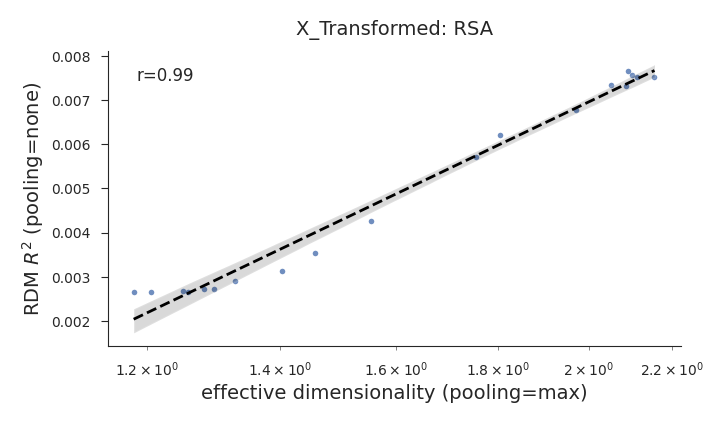

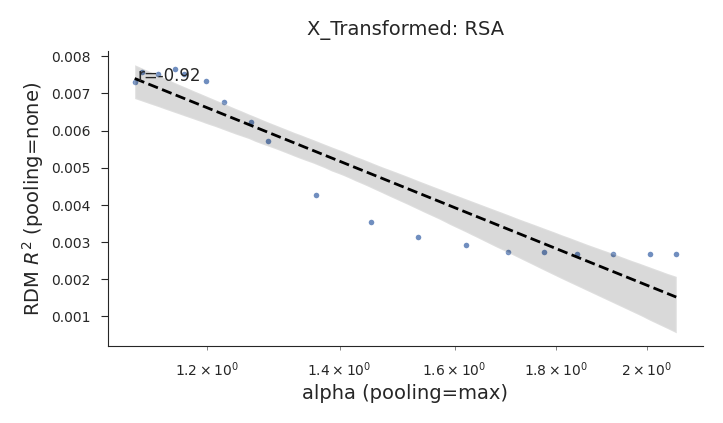

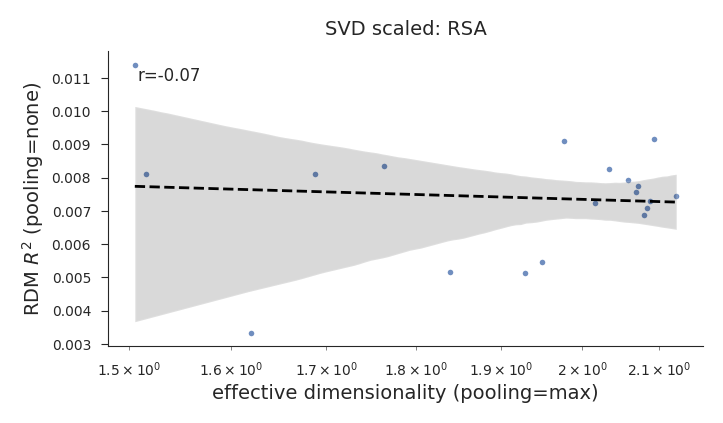

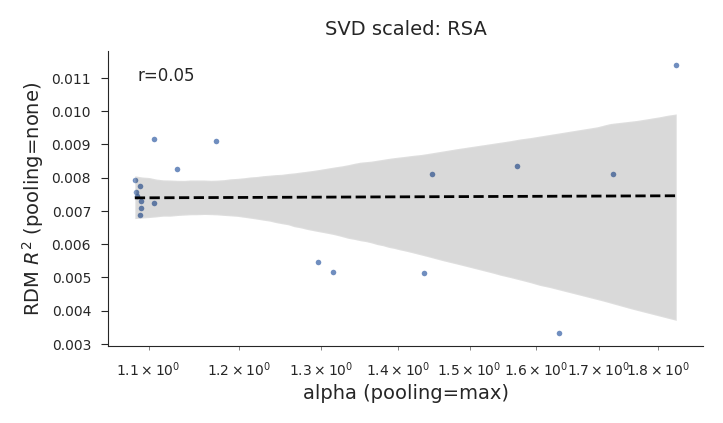

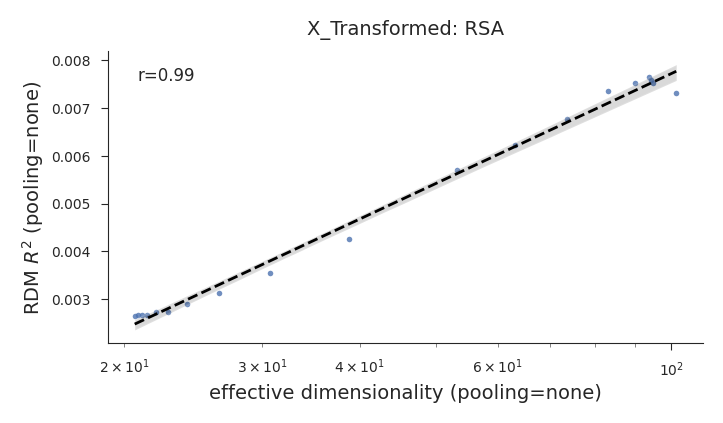

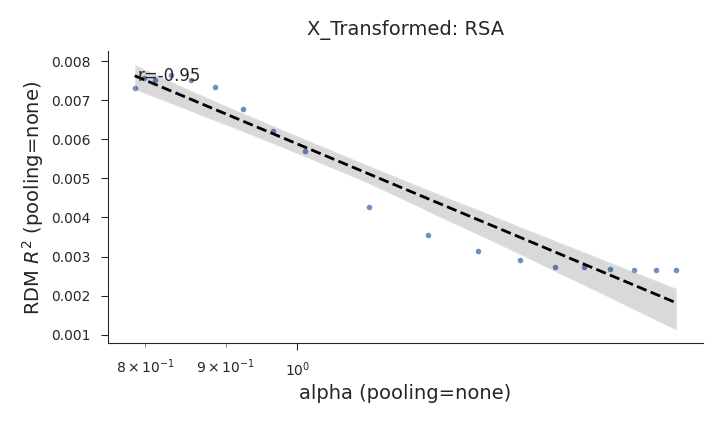

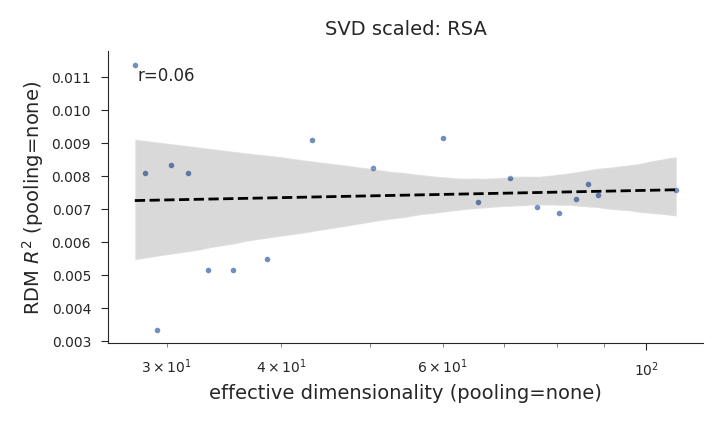

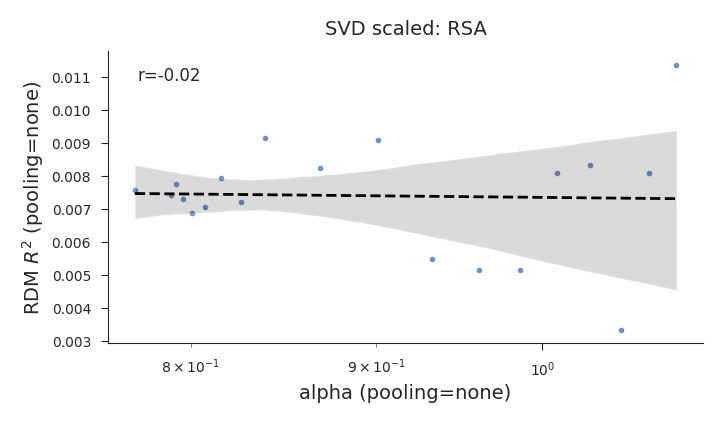

In [7]:
#RSA:

enc_files = ['Eig', 'SVD']
#'Eigall',  'SVD4', 'SVD-scaled2'
pooling = ['max', 'none']

spectra = False
encoding = True

for p in pooling:

    #eigenspectra

    if spectra:
        
        f = spec_file
        if f == 'SVD-Reg':
            t = f'SVD (pooling={p})'
        if f == 'ScaledSVD-Reg':
            t = f'Scaled SVD (pooling={p})'

        dm = pd.read_csv(f'../../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        ds = pd.read_csv(f'../../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        data = pd.merge(dm, ds, on=id_columns)
        data['id'] = data[id_columns].sum(axis='columns')
        data = data[ (data['layer']=='c2') ]
        
    # Remove outlier low-variance points at the final PCs
        def is_outlier(i):
            i = np.log(i)
            cutoff = 0.95 * i.iloc[-1]
            return i > cutoff
        outlier = data.groupby(id_columns)['n'].transform(is_outlier)
        data = data[~outlier]

    # Set y-intercept to 1
        def get_scaled_var(x):
            i, y = x['n'].values, x['variance'].values
            i, y = np.log(i), np.log(y)
            intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
            intercept = np.exp(intercept)
            return x['variance'] / intercept
        scaled_var = data.groupby(id_columns).apply(get_scaled_var)
        scaled_var = scaled_var.reset_index(id_columns, drop=True)
        data['scaled_variance'] = scaled_var

    # Log(ED)
        data['log_ed'] = np.log10(data['effective dimensionality'])

        fig, ax = plt.subplots(figsize=(3, 3))
        sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                    units='id', alpha=0.2, estimator=None,
                    palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
        ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
        ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
        ax.set_ylim(bottom=10**(-9), top=10**4)
        ax.legend(title='Weights Powerlaw Slope')
        #ax.legend(title=r'$\log{(ED)}$')
        #plt.show()
            
            
        #encoding score
        
    if encoding:
            
        for f in enc_files:

            if f == 'Eig':
                f_spec = 'Eig-Reg'
                t = 'X_Transformed: RSA'
            elif f == 'SVD':
                f_spec = 'ScaledSVD-Reg'
                t = 'SVD scaled: RSA'
                
            
            dm = pd.read_csv(f'../../../results_marcc/atlasnet/eigmetrics_{f_spec}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
            if f == 'SVD-OLS_plot':
                dm = dm[ (dm['task'] != 'SVD-Reg_-0.3')]
                dm.reset_index(drop=True, inplace=True)
            de = pd.read_csv(f'../../../results_marcc/atlasnet/rsa_{f}|benchmark:dicarlo.MajajHong2015.IT.public-rsa|pooling:False.csv')
            dm['task'] = de['task']
            data = pd.merge(de, dm, on=id_columns)
            data = data[ (data['layer']=='c2') ]
            data['id'] = data[id_columns].sum(axis='columns')

            predictors = ['effective dimensionality', 'alpha']
            for pred in predictors:
                r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                sns.regplot(data=data, x=pred, y='score', 
                            logx=True,
                            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                            ax=ax)
                ax.set(xlabel=f'{pred} (pooling={p})', ylabel=r'RDM $R^2$ (pooling=none)', xscale='log', title=t)
                ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                #ax.set_ylim(bottom=0, top=0.65)
                #ax.set_xlim(0.8, 270)

plt.show()

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:97: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


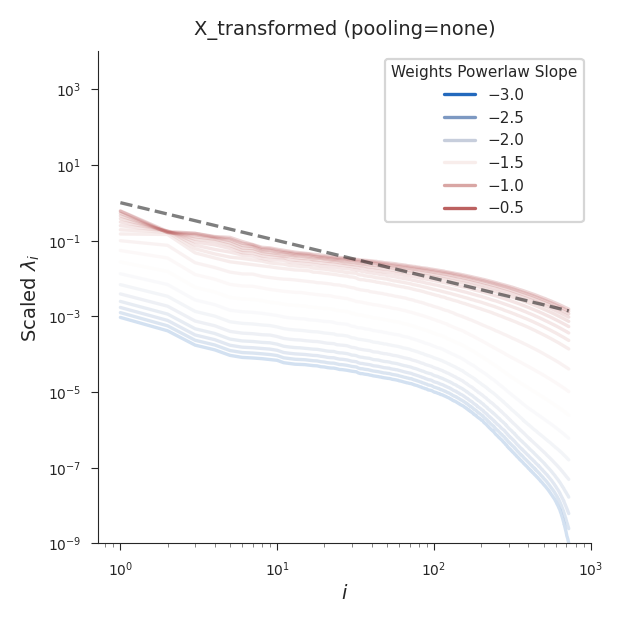

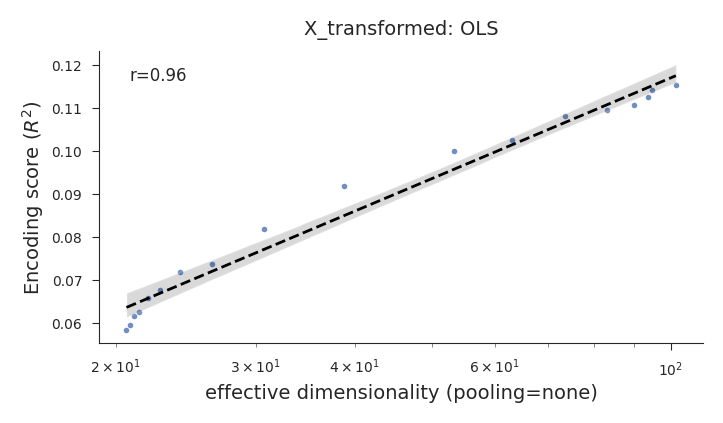

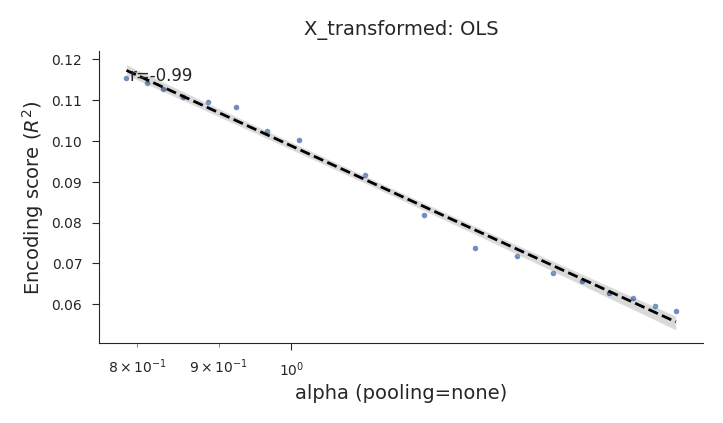

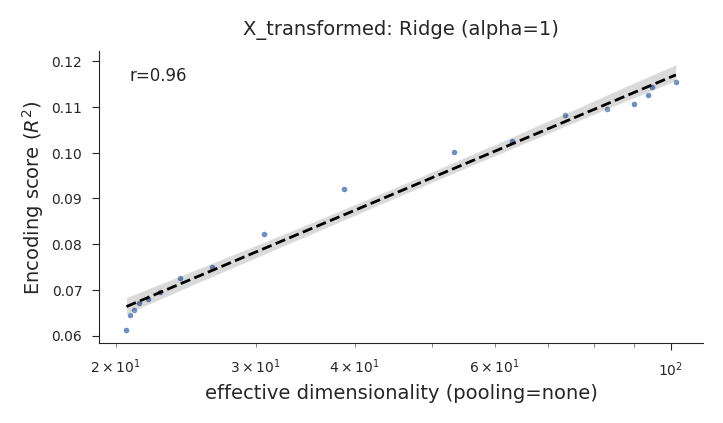

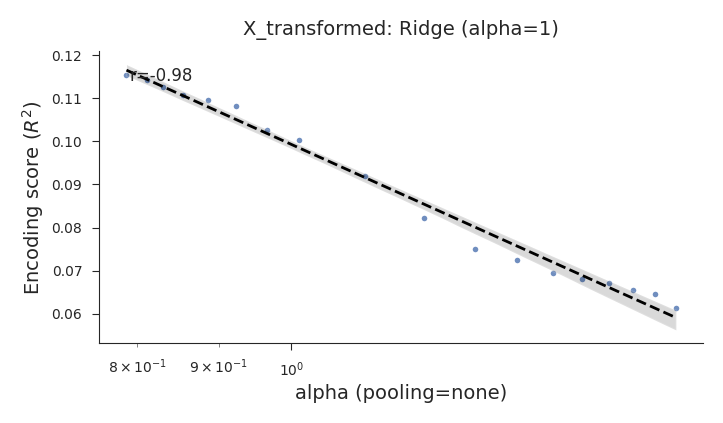

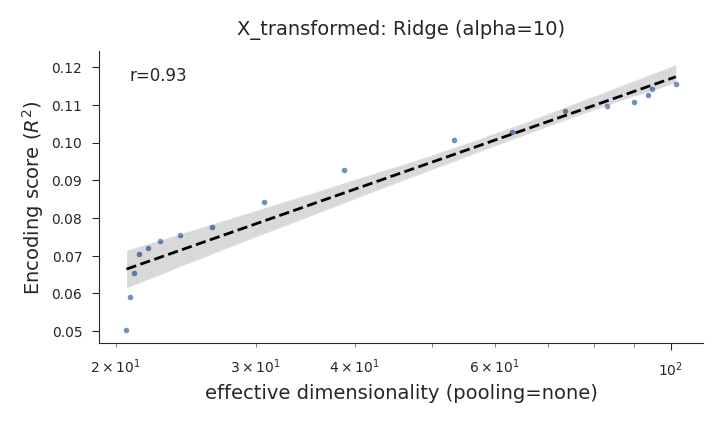

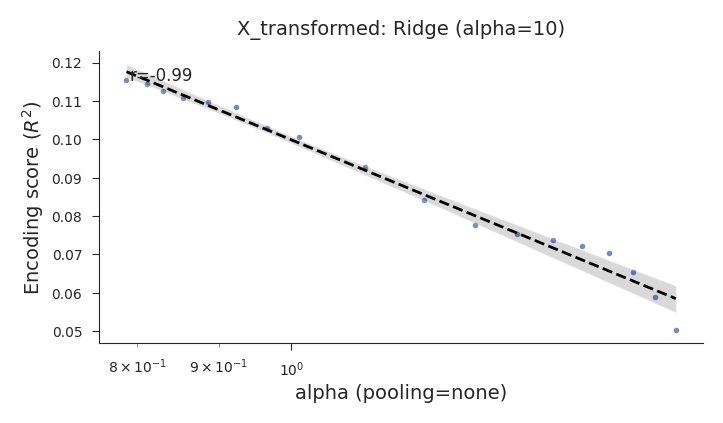

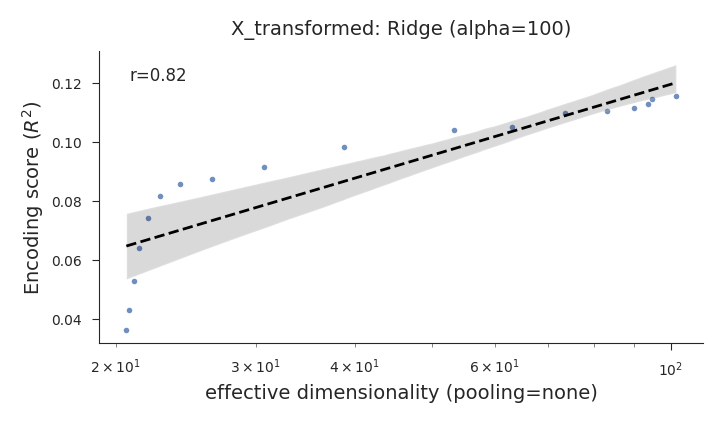

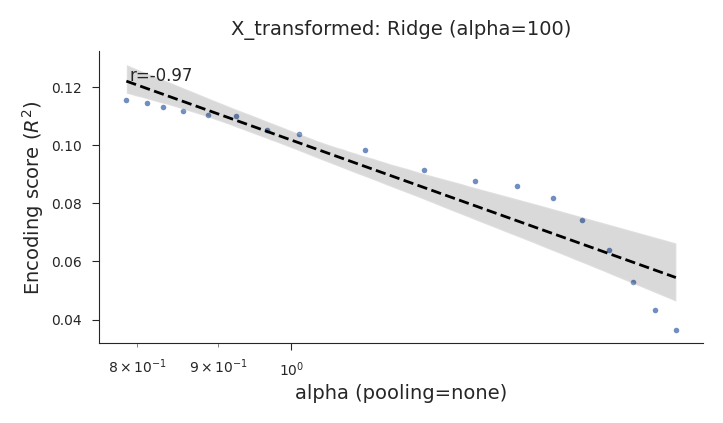

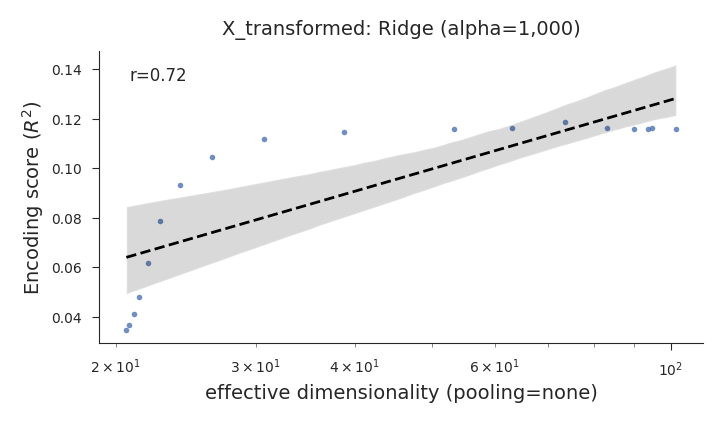

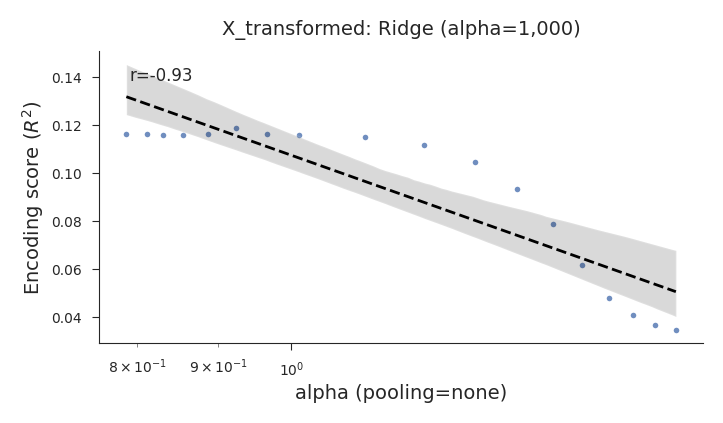

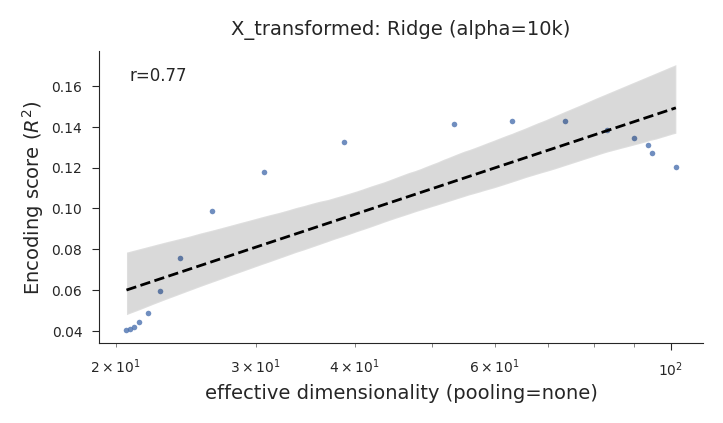

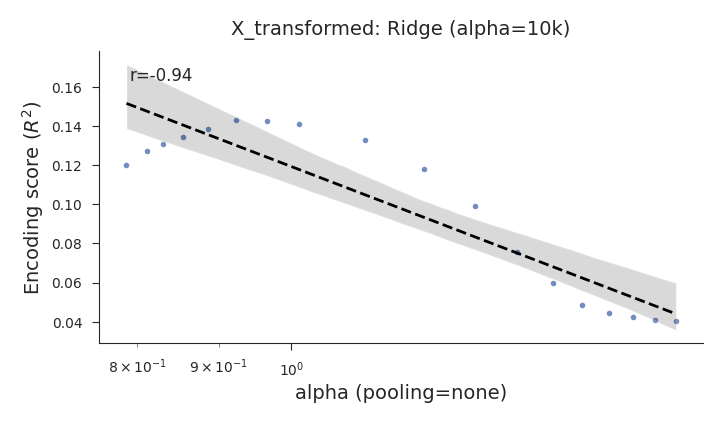

In [4]:
spec_file = 'Eig-Reg'
enc_files = ['Eig-OLS_plot', 'Eig-Ridge1_plot', 'Eig-Ridge10_plot','Eig-Ridge100_plot','Eig-Ridge1000_plot','Eig-Ridge10k_plot']
#'Eigall',  'SVD4', 'SVD-scaled2'

ridge_alphas = [1, 10, 100, 1000, 10000]
eig_slopes = [-0.2, -0,3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.2, -1.4, -1.6, -1.8, -2, -2.2, -2.4, -2.6, -2.8, -3]

# ** set kind (or task) equal to eig_slopes for plotting hue = slope

spectra = True
encoding = True
p = 'none'


    
    #eigenspectra

if spectra:
    
    f = spec_file
    t = f'X_transformed (pooling={p})'

    dm = pd.read_csv(f'../../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
    ds = pd.read_csv(f'../../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
    data = pd.merge(dm, ds, on=id_columns)
    data['id'] = data[id_columns].sum(axis='columns')
    data = data[ (data['layer']=='c2') ]
    
# Remove outlier low-variance points at the final PCs
    def is_outlier(i):
        i = np.log(i)
        cutoff = 0.95 * i.iloc[-1]
        return i > cutoff
    outlier = data.groupby(id_columns)['n'].transform(is_outlier)
    data = data[~outlier]

# Set y-intercept to 1
    def get_scaled_var(x):
        i, y = x['n'].values, x['variance'].values
        i, y = np.log(i), np.log(y)
        intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
        intercept = np.exp(intercept)
        return x['variance'] / intercept
    scaled_var = data.groupby(id_columns).apply(get_scaled_var)
    scaled_var = scaled_var.reset_index(id_columns, drop=True)
    data['scaled_variance'] = scaled_var

# Log(ED)
    data['log_ed'] = np.log10(data['effective dimensionality'])

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                units='id', alpha=0.2, estimator=None,
                palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
    ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
    ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
    ax.set_ylim(bottom=10**(-9), top=10**4)
    ax.legend(title='Weights Powerlaw Slope')
    #ax.legend(title=r'$\log{(ED)}$')
    #plt.show()
        
        
    #encoding score
    
    if encoding:
        f_spec = spec_file
        
        for f in enc_files:

            if f == 'Eig-OLS_plot':
                t = 'X_transformed: OLS'
                reg = 'lin'
            elif f == 'Eig-Ridge1_plot':
                t = 'X_transformed: Ridge (alpha=1)'
                reg = 'ridge_alpha=1'
            elif f == 'Eig-Ridge10_plot':
                t = 'X_transformed: Ridge (alpha=10)'
                reg = 'ridge_alpha=10'
            elif f == 'Eig-Ridge100_plot':
                t = 'X_transformed: Ridge (alpha=100)'
                reg = 'ridge_alpha=100'
            elif f == 'Eig-Ridge1000_plot':
                t = 'X_transformed: Ridge (alpha=1,000)'
                reg = 'ridge_alpha=1000'
            elif f == 'Eig-Ridge10k_plot':
                t = 'X_transformed: Ridge (alpha=10k)'
                reg = 'ridge_alpha=10000'
        
        
            dm = pd.read_csv(f'../../../results_marcc/atlasnet/eigmetrics_{f_spec}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
            dm = dm[ (dm['task'] != 'Eig-Reg_-0.3')]
            dm.reset_index(drop=True, inplace=True)
            de = pd.read_csv(f'../../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
            dm['task'] = de['task']
            data = pd.merge(de, dm, on=id_columns)
            data = data[ (data['layer']=='c2') ]
            data['id'] = data[id_columns].sum(axis='columns')

            predictors = ['effective dimensionality', 'alpha']
            for pred in predictors:
                r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                sns.regplot(data=data, x=pred, y='score', 
                            logx=True,
                            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                            ax=ax)
                ax.set(xlabel=f'{pred} (pooling={p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
                ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                #ax.set_ylim(bottom=0, top=0.65)
                #ax.set_xlim(0.8, 270)

plt.show()

In [ ]:
import pandas as pd
# ** set kind (or task) equal to eig_slopes for plotting hue = slope
#get rid of Eig-OLS0, Eig-OLS3, EigRidge1_0, EigRidge1_3, etc.
file = 'SVD-OLS'
reg = 'lin'

d1 = pd.read_csv(f'../../results_marcc/atlasnet/encoding_{file}|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
d1 = d1[ (d1['task'] != 'SVD-OLS0')]
d1 = d1[ (d1['task'] != 'SVD-OLS3')]
d1.reset_index(drop=True, inplace=True)


eig_slopes = [-0.2, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.2, -1.4, -1.6, -1.8, -2, -2.2, -2.4, -2.6, -2.8, -3]
for e in eig_slopes:
    i = eig_slopes.index(e)
    for l in range(2):
        row = i + i + l
        d1.iat[row, 5] = e

#print(d1)
d1.to_csv(f'../../results_marcc/atlasnet/encoding_{file}_plot|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')


/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:110: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


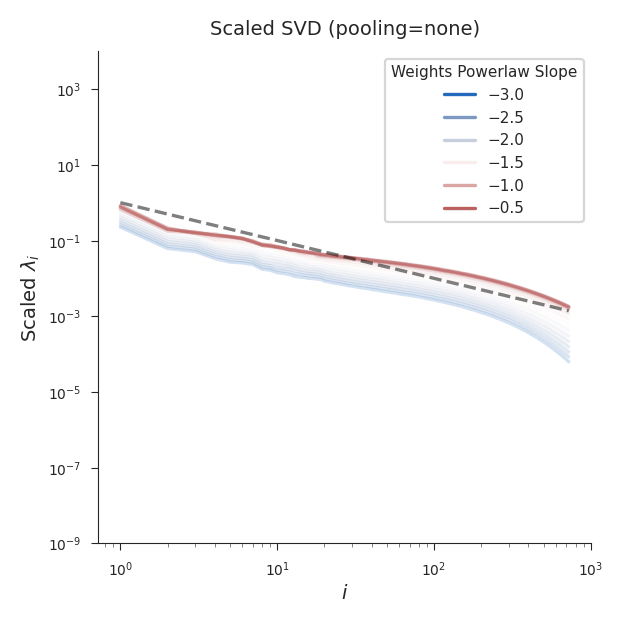

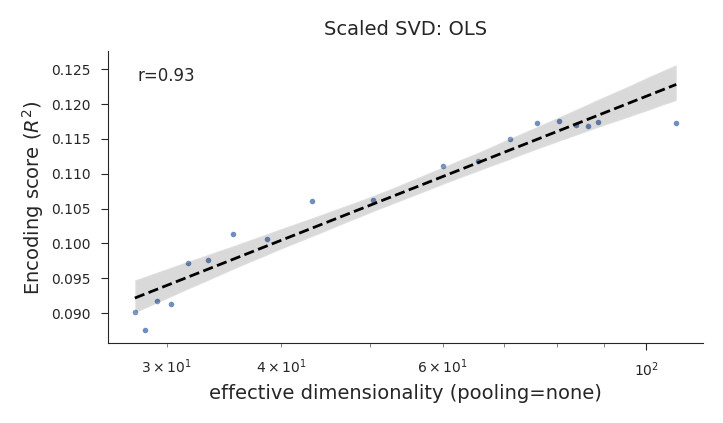

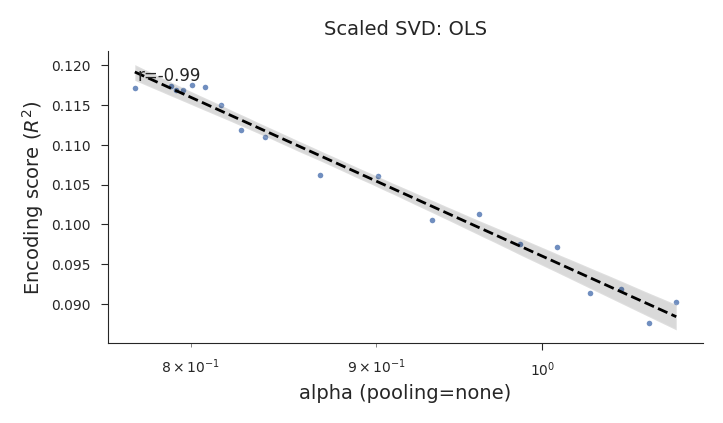

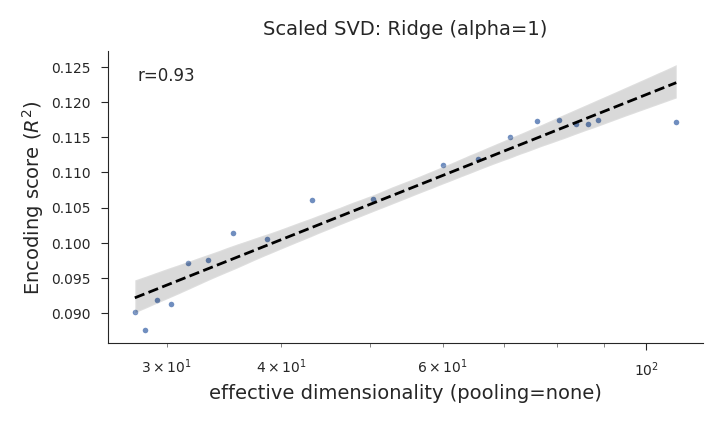

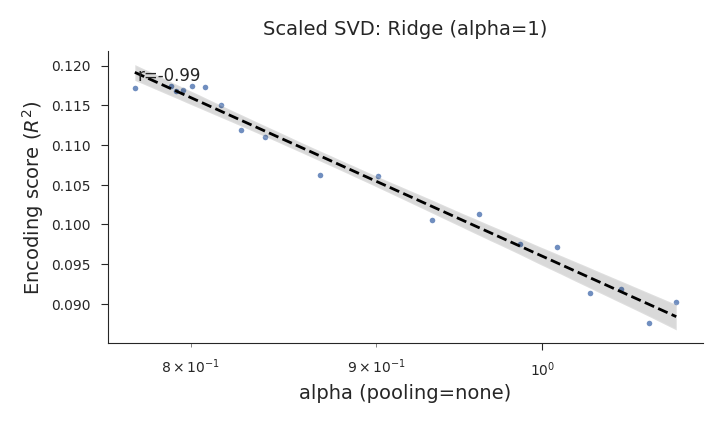

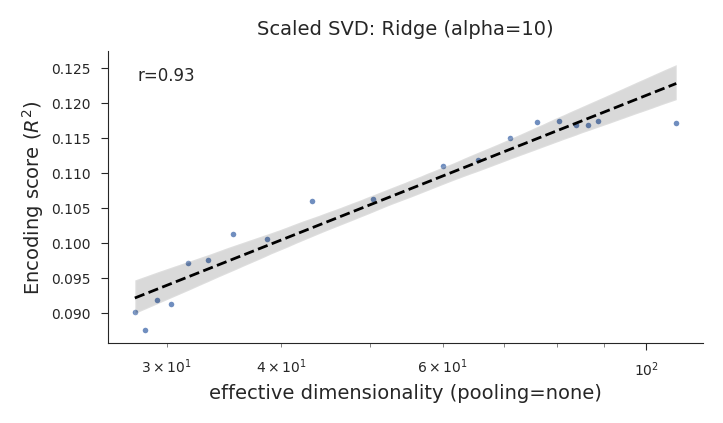

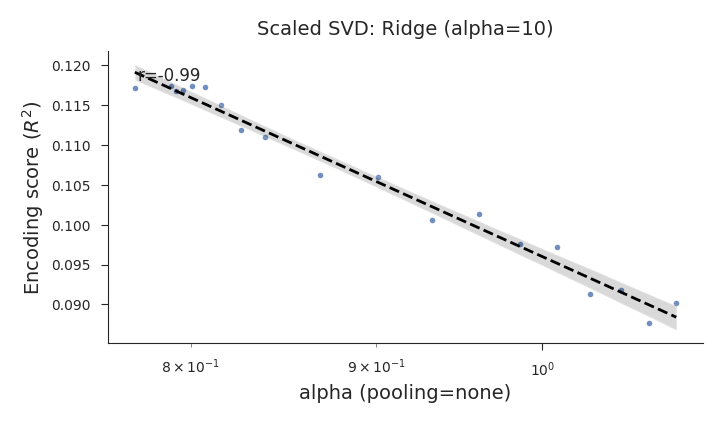

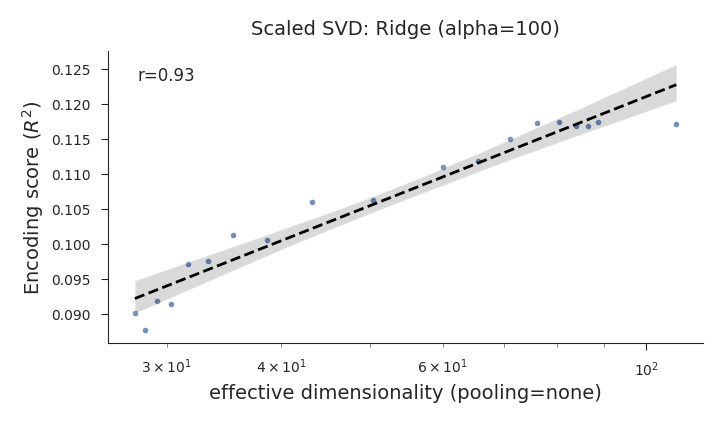

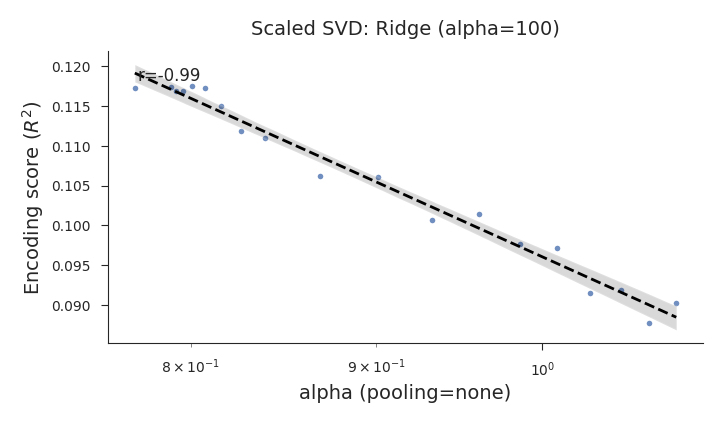

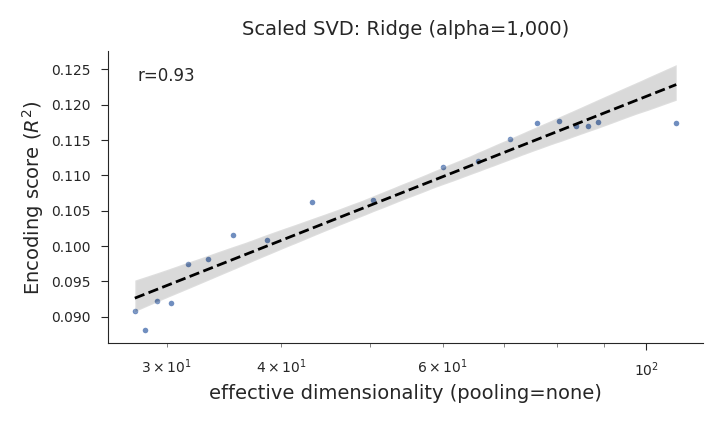

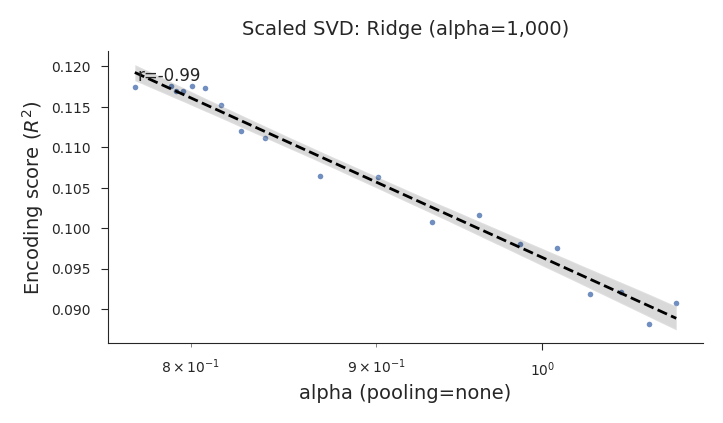

In [5]:
#spec_file = 'SVD-Reg'
spec_file = 'ScaledSVD-Reg'
#enc_files = ['SVD-OLS_plot', 'SVD-Ridge1', 'SVD-Ridge10', 'SVD-Ridge100', 'SVD-Ridge1000']
enc_files = ['ScaledSVD-OLS', 'ScaledSVD-Ridge1', 'ScaledSVD-Ridge10', 'ScaledSVD-Ridge100', 'ScaledSVD-Ridge1000']
#'Eigall',  'SVD4', 'SVD-scaled2'

spectra = True
encoding = True
p = 'none'


#eigenspectra

if spectra:
    
    f = spec_file
    if f == 'SVD-Reg':
        t = f'SVD (pooling={p})'
    if f == 'ScaledSVD-Reg':
        t = f'Scaled SVD (pooling={p})'

    dm = pd.read_csv(f'../../../results_marcc/atlasnet/eigmetrics_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
    ds = pd.read_csv(f'../../../results_marcc/atlasnet/eigspectra_{f}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
    data = pd.merge(dm, ds, on=id_columns)
    data['id'] = data[id_columns].sum(axis='columns')
    data = data[ (data['layer']=='c2') ]
    
# Remove outlier low-variance points at the final PCs
    def is_outlier(i):
        i = np.log(i)
        cutoff = 0.95 * i.iloc[-1]
        return i > cutoff
    outlier = data.groupby(id_columns)['n'].transform(is_outlier)
    data = data[~outlier]

# Set y-intercept to 1
    def get_scaled_var(x):
        i, y = x['n'].values, x['variance'].values
        i, y = np.log(i), np.log(y)
        intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
        intercept = np.exp(intercept)
        return x['variance'] / intercept
    scaled_var = data.groupby(id_columns).apply(get_scaled_var)
    scaled_var = scaled_var.reset_index(id_columns, drop=True)
    data['scaled_variance'] = scaled_var

# Log(ED)
    data['log_ed'] = np.log10(data['effective dimensionality'])

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                units='id', alpha=0.2, estimator=None,
                palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
    ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
    ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
    ax.set_ylim(bottom=10**(-9), top=10**4)
    ax.legend(title='Weights Powerlaw Slope')
    #ax.legend(title=r'$\log{(ED)}$')
    #plt.show()
        
        
    #encoding score
    
    if encoding:
        f_spec = spec_file
        
        for f in enc_files:

            if f == 'SVD-OLS_plot':
                t = 'SVD: OLS'
                reg = 'lin'
            elif f == 'SVD-Ridge1':
                t = 'SVD: Ridge (alpha=1)'
                reg = 'ridge_alpha=1'
            elif f == 'SVD-Ridge10':
                t = 'SVD: Ridge (alpha=10)'
                reg = 'ridge_alpha=10'
            elif f == 'SVD-Ridge100':
                t = 'SVD: Ridge (alpha=100)'
                reg = 'ridge_alpha=100'
            elif f == 'SVD-Ridge1000':
                t = 'SVD: Ridge (alpha=1,000)'
                reg = 'ridge_alpha=1000'
            
            elif f == 'ScaledSVD-OLS':
                t = 'Scaled SVD: OLS'
                reg = 'lin'
            elif f == 'ScaledSVD-Ridge1':
                t = 'Scaled SVD: Ridge (alpha=1)'
                reg = 'ridge_alpha=1'
            elif f == 'ScaledSVD-Ridge10':
                t = 'Scaled SVD: Ridge (alpha=10)'
                reg = 'ridge_alpha=10'
            elif f == 'ScaledSVD-Ridge100':
                t = 'Scaled SVD: Ridge (alpha=100)'
                reg = 'ridge_alpha=100'
            elif f == 'ScaledSVD-Ridge1000':
                t = 'Scaled SVD: Ridge (alpha=1,000)'
                reg = 'ridge_alpha=1000'
        
        
            dm = pd.read_csv(f'../../../results_marcc/atlasnet/eigmetrics_{f_spec}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
            if f == 'SVD-OLS_plot':
                dm = dm[ (dm['task'] != 'SVD-Reg_-0.3')]
                dm.reset_index(drop=True, inplace=True)
            de = pd.read_csv(f'../../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
            dm['task'] = de['task']
            data = pd.merge(de, dm, on=id_columns)
            data = data[ (data['layer']=='c2') ]
            data['id'] = data[id_columns].sum(axis='columns')

            predictors = ['effective dimensionality', 'alpha']
            for pred in predictors:
                r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                sns.regplot(data=data, x=pred, y='score', 
                            logx=True,
                            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                            ax=ax)
                ax.set(xlabel=f'{pred} (pooling={p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
                ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                #ax.set_ylim(bottom=0, top=0.65)
                #ax.set_xlim(0.8, 270)

plt.show()